In [12]:
!ls  pretrained_checkpoint/ -la 

total 4138652
drwxrwxr-x  2 chauh chauh       4096 Jul 16 09:48 .
drwxrwxr-x 12 chauh chauh       4096 Jul 17 11:13 ..
-rw-rw-r--  1 chauh chauh  375042383 Jul 16 09:48 sam_vit_b_01ec64.pth
-rw-rw-r--  1 chauh chauh   16276049 Jul 16 09:47 sam_vit_b_maskdecoder.pth
-rw-rw-r--  1 chauh chauh 2564550879 Jul 16 09:48 sam_vit_h_4b8939.pth
-rw-rw-r--  1 chauh chauh   16276049 Jul 16 09:47 sam_vit_h_maskdecoder.pth
-rw-rw-r--  1 chauh chauh 1249524607 Jul 16 09:48 sam_vit_l_0b3195.pth
-rw-rw-r--  1 chauh chauh   16276049 Jul 16 09:47 sam_vit_l_maskdecoder.pth


In [20]:

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor
import os

sam_ckt = './pretrained_checkpoint/sam_vit_b_01ec64.pth'
model_type = 'vit_b'
device = 'cuda'
sam = sam_model_registry[model_type](checkpoint=sam_ckt)
sam.to(device=device)
predictor = SamPredictor(sam)



_IncompatibleKeys(missing_keys=['mask_decoder.hf_token.weight', 'mask_decoder.hf_mlp.layers.0.weight', 'mask_decoder.hf_mlp.layers.0.bias', 'mask_decoder.hf_mlp.layers.1.weight', 'mask_decoder.hf_mlp.layers.1.bias', 'mask_decoder.hf_mlp.layers.2.weight', 'mask_decoder.hf_mlp.layers.2.bias', 'mask_decoder.compress_vit_feat.0.weight', 'mask_decoder.compress_vit_feat.0.bias', 'mask_decoder.compress_vit_feat.1.weight', 'mask_decoder.compress_vit_feat.1.bias', 'mask_decoder.compress_vit_feat.3.weight', 'mask_decoder.compress_vit_feat.3.bias', 'mask_decoder.embedding_encoder.0.weight', 'mask_decoder.embedding_encoder.0.bias', 'mask_decoder.embedding_encoder.1.weight', 'mask_decoder.embedding_encoder.1.bias', 'mask_decoder.embedding_encoder.3.weight', 'mask_decoder.embedding_encoder.3.bias', 'mask_decoder.embedding_maskfeature.0.weight', 'mask_decoder.embedding_maskfeature.0.bias', 'mask_decoder.embedding_maskfeature.1.weight', 'mask_decoder.embedding_maskfeature.1.bias', 'mask_decoder.embedd

In [25]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


def show_res(masks, scores, input_point, input_label, input_box, filename, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None): 
            show_points(input_point, input_label, plt.gca())
        
        print(f"Score: {score:.3f}")
        plt.axis('off')
        plt.savefig(filename+'_'+str(i)+'.png',bbox_inches='tight',pad_inches=-0.1)
        plt.close()

def show_res_multi(masks, scores, input_point, input_label, input_box, filename, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.savefig(filename +'.png',bbox_inches='tight',pad_inches=-0.1)
    plt.show()
    # plt.close()

image:    0
Score: 0.815
image:    1
Score: 0.966
image:    2
Score: 0.905
image:    3
Score: 0.782
image:    4
Score: 0.757
image:    5
Score: 0.927
image:    6
Score: 0.967
image:    7
Score: 0.875
Score: 0.963


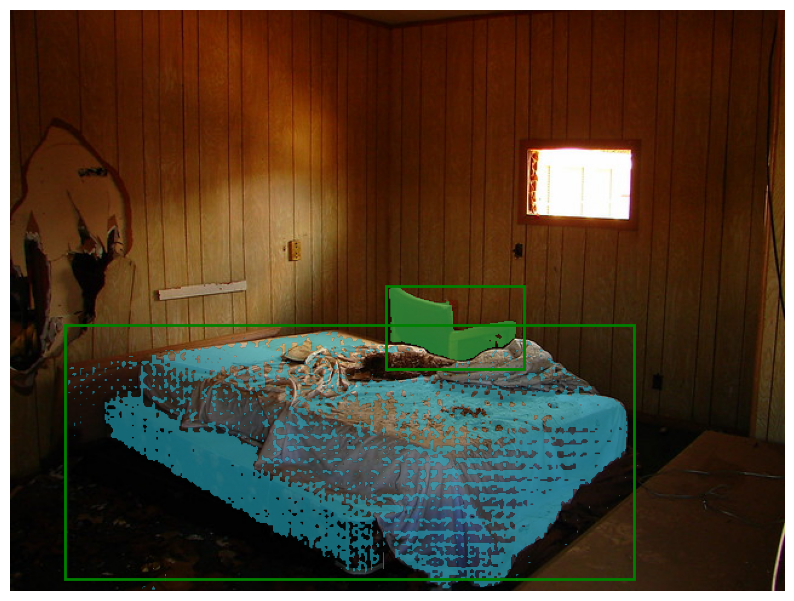

In [26]:
for i in range(8):
    print("image:   ",i)
    # hq_token_only: False means use hq output to correct SAM output. 
    #                True means use hq output only. 
    #                Default: False
    hq_token_only = False 
    # To achieve best visualization effect, for images contain multiple objects (like typical coco images), we suggest to set hq_token_only=False
    # For images contain single object, we suggest to set hq_token_only = True
    # For quantiative evaluation on COCO/YTVOS/DAVIS/UVO/LVIS etc., we set hq_token_only = False

    path = 'sam-hq/demo/input_imgs/example'
    image = cv2.imread(path+str(i)+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    if i==0:
        input_box = np.array([[4,13,1007,1023]])
        input_point, input_label = None, None
    elif i==1:
        input_box = np.array([[306, 132, 925, 893]])
        input_point, input_label = None, None
        hq_token_only = True
    elif i==2:
        input_point = np.array([[495,518],[217,140]])
        input_label = np.ones(input_point.shape[0])
        input_box = None
        hq_token_only = True
    elif i==3:
        input_point = np.array([[221,482],[498,633],[750,379]])
        input_label = np.ones(input_point.shape[0])
        input_box = None
    elif i==4:
        input_box = np.array([[64,76,940,919]])
        input_point, input_label = None, None
        hq_token_only = True
    elif i==5:
        input_point = np.array([[373,363], [452, 575]])
        input_label = np.ones(input_point.shape[0])
        input_box = None
    elif i==6:
        input_box = np.array([[181, 196, 757, 495]])
        input_point, input_label = None, None
    elif i==7:
        # multi box input
        input_box = torch.tensor([[45,260,515,470], [310,228,424,296]],device=predictor.device)
        transformed_box = predictor.transform.apply_boxes_torch(input_box, image.shape[:2])
        input_point, input_label = None, None

    batch_box = False if input_box is None else len(input_box)>1 
    result_path = 'demo/hq_sam_result/'
    os.makedirs(result_path, exist_ok=True)

    if not batch_box: 
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            box = input_box,
            multimask_output=False,
            hq_token_only=hq_token_only, 
        )
        show_res(masks,scores,input_point, input_label, input_box, result_path + 'example'+str(i), image)
    
    else:
        masks, scores, logits = predictor.predict_torch(
            point_coords=input_point,
            point_labels=input_label,
            boxes=transformed_box,
            multimask_output=False,
            hq_token_only=hq_token_only,
        )
        masks = masks.squeeze(1).cpu().numpy()
        scores = scores.squeeze(1).cpu().numpy()
        input_box = input_box.cpu().numpy()
        show_res_multi(masks, scores, input_point, input_label, input_box, result_path + 'example'+str(i), image)
